# Text Image Segmentation for Optimal Optical character recognition

Optical character recognition (OCR) aims to recognize texts in imaged documents. It is probably one of the earliest computer vision techniques that have been commercialized successfully. OCR usually involves a series of image processing and recognition tasks including 1) text image binarization that converts a colour/grayscale image into a binary image with multiple foreground regions (usually characters); 2) connected component labelling that detects each binarized character region; 3) character recognition by using some classifiers such as a pre-trained neural network.

In this project, you need to explore and develop various image binarization algorithms targeting the optimal character recognition accuracy. You do not need to develop OCR algorithm but use an open-source OCR software Tesseract: https://github.com/tesseract-ocr/tesseract. You can google the keyword "Tesseract" to search for more information about how to use this software. In addition, you just need to work on either one (or both) of the two sample text images that can be downloaded from the project website in NTULearn.

In [2]:
# import the relevant libraries
from matplotlib import pyplot as plt

import numpy as np
import pytesseract
import cv2

In [3]:
# load the image
image = cv2.imread('images/sample01.png', cv2.IMREAD_GRAYSCALE)

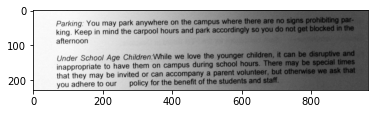

In [4]:
# view the image
plt.imshow(image, cmap='gray')
plt.show()

In [5]:
# try using Tesseract on an image as is
text = pytesseract.image_to_string(image)
print(text)

Parking: You may park anywhere on the ce
king. Keep in mind the carpool hours and park
afternoon

Under School Age Children:While we love
inappropriate to have them on campus @ )
that they may be invited or can accompany :
you adhere to our _ policy for the benefit of

 



This project consists of the following tasks:

1) Implement the Ostu global thresholding algorithm for binarizing the sample text images and feed the binairzed images to the OCR software to evaluate the OCR accuracy. Discuss any problems with the Otsu global thresholding algorithm.

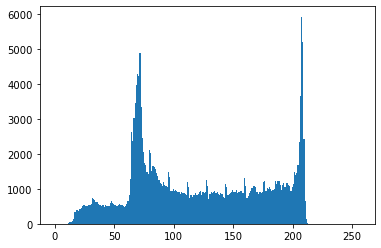

In [6]:
# confirm histogram is bimodal
plt.hist(
    x=image.ravel(),
    bins=256,
    range=[0, 256],
)
plt.show()

In [7]:
def otsu_threshold(image: np.ndarray) -> np.ndarray:
    '''
    Otsu threshold, done the standard way.
    
    The mask that is obtained can be used to binarize the image, by doing: 
    np.where(image > threshold_mask, 255, 0)

    :params:
    - image (np.ndarray): the image to find the threshold of

    :return:
    - mask of threshold (np.ndarray)
    '''
    histogram = cv2.calcHist(
        images=[image],
        channels=[0],
        mask=None,
        histSize=[256],
        ranges=[0, 256],
    )

    num_pixels = image.size

    gray_level_probabilities = [
        bin_count[0] / num_pixels
        for bin_count in histogram
    ]
    
    best_threshold = -1
    min_intraclass_variance = float('inf')

    for threshold in range(len(histogram)):  # 0 to 255
        lower_group_probability = sum(gray_level_probabilities[:threshold+1])
        upper_group_probability = sum(gray_level_probabilities[threshold+1:])

        if lower_group_probability == 0 or upper_group_probability == 0:
            continue  # otherwise, divide by 0

        lower_group_mean = sum([
            gray_level * probability  # gray level == pixel value
            for gray_level, probability in enumerate(gray_level_probabilities[:threshold+1])
        ]) / lower_group_probability

        upper_group_mean = sum([
            gray_level * probability
            for gray_level, probability in enumerate(gray_level_probabilities[threshold+1:])
        ]) / upper_group_probability

        lower_group_variance = sum([
            ((gray_level - lower_group_mean)**2) * probability
            for gray_level, probability in enumerate(gray_level_probabilities[:threshold+1])
        ]) / lower_group_probability

        upper_group_variance = sum([
            ((gray_level - upper_group_mean)**2) * probability
            for gray_level, probability in enumerate(gray_level_probabilities[threshold+1:])
        ]) / upper_group_probability

        intraclass_variance = lower_group_probability * lower_group_variance + \
            upper_group_probability * upper_group_variance

        if intraclass_variance < min_intraclass_variance:
            min_intraclass_variance = intraclass_variance
            best_threshold = threshold

    return np.full_like(image, fill_value=best_threshold)

In [8]:
# binarize the image
threshold_mask = otsu_threshold(image)
binarized_image = np.where(image > threshold_mask, 255, 0)
binarized_image = binarized_image.astype(np.uint8)  # right type for Tesseract

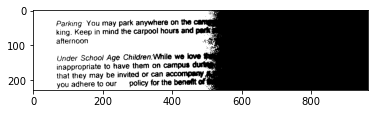

In [9]:
# view the binarized image
plt.imshow(binarized_image, cmap='gray')
plt.show()

In [10]:
# try using Tesseract on the binarized image
# should get left-half of text, like before
text = pytesseract.image_to_string(binarized_image)
print(text)

Parking You may park anywhere on the cf
king. Keep in mind the carpool hours and peri,
afternoon

Under School Age Children:While we love
inappropriate to have them on campus @ i
that they may be invited or can accompany J
you adhere to our —_policy for the benefit of

 



2) Design your own algorithms to address the problem of Otsu global thresholding algorithm, and evaluate OCR accuracy for the binary images as produced by your algorithms. You may explore different approaches such as adaptive thresholding, image enhancement, etc., and the target is to achieve the best OCR accuracy.

In [11]:
# try splitting image into segments,
# then perform Otsu's algorithm on each
def segmented_otsu_threshold(
    image: np.ndarray,
    num_vertical_segments: int = 2,
    num_horizontal_segments: int = 2,
) -> np.ndarray:
    '''
    Otsu threshold, done on segments of the image.
    
    Total number of segments = num_vertical_segments * num_horizontal_segments

    The mask that is obtained can be used to binarize the image, by doing: 
    np.where(image > threshold_mask, 255, 0)

    :params:
    - image (np.ndarray): the image to find the threshold of

    :return:
    - mask of threshold (np.ndarray)
    '''
    image_height, image_length = image.shape

    segment_height = image_height // num_vertical_segments + 1
    segment_length = image_length // num_horizontal_segments + 1

    threshold_mask = np.zeros_like(image)

    for vertical_offset in range(0, image_height, segment_height):
        for horizontal_offset in range(0, image_length, segment_length):
            image_segment = image[
                vertical_offset: vertical_offset + segment_height,
                horizontal_offset: horizontal_offset + segment_length
            ]

            segmented_threshold_mask = otsu_threshold(image_segment)

            threshold_mask[
                vertical_offset: vertical_offset + segment_height,
                horizontal_offset: horizontal_offset + segment_length
            ] = segmented_threshold_mask
            
    return threshold_mask

In [12]:
# binarize the image
threshold_mask = segmented_otsu_threshold(
    image=image,
    num_vertical_segments=2,
    num_horizontal_segments=4,
)
binarized_image = np.where(image > threshold_mask, 255, 0)
binarized_image = binarized_image.astype(np.uint8)  # right type for Tesseract

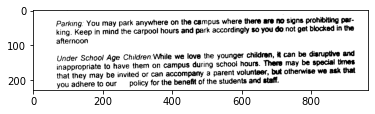

In [13]:
# view the binarized image
plt.imshow(binarized_image, cmap='gray')
plt.show()

In [14]:
# try using Tesseract on the binarized image
# should get the full text
text = pytesseract.image_to_string(binarized_image)
print(text)

Parking: You may park anywhere on the campus where there are no signs prohibiting par-
king. Keep in mind the carpool hours and park accordingly $0 you do.not get blocked in the
afternoon

Under School Age Children:While we love the younger children, # can be disruptive and
inappropriate to have them on campus during school hours. There may be special times
that they may be invited or can accompany a parent volunteer, but otherwise we ask that
you adhere to our —_ policy for the benefit of the students and staff.



3) Discuss how to improve recognition algorithms for more robust and accurate character recognition while document images suffer from different types of image degradation. This is an open and optional task. There will be bonus points if you have good ideas on it.

In [15]:
# TODO